## Recurrent Neural Network (LSTM) | Multivariate

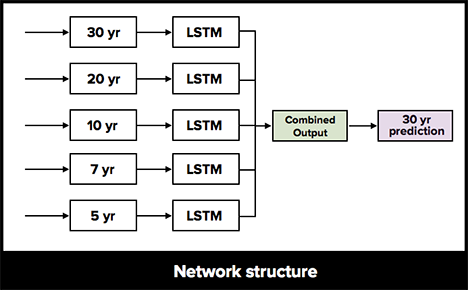

In [1]:
from IPython.display import Image
Image(filename='../images/multivar_RNN_structure.png')

In [2]:
# general import environment
print('versions')
print ('------------')
import pandas as pd
print('pandas: ', pd.__version__)
pd.set_option('display.max_columns', None)
import numpy as np
print('numpy: ', np.__version__)
import time as time
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
print('mpl: ', mpl.__version__)
%matplotlib inline

from sklearn.metrics import mean_squared_error

versions
------------
pandas:  0.20.3
numpy:  1.13.3
mpl:  2.0.2


In [3]:
# load keras/tf models
# import keras/tensorflow layers for RNN
import math
from keras.models import Sequential
# from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM, Merge, Activation, Dense, Dropout
from keras import regularizers

Using TensorFlow backend.


In [4]:
# anchor random seed (numpy)
np.random.seed(1)

### load cached data

In [5]:
#### load cached data
temporal_group = 'monthly'
df = pd.read_csv('../data/historical_data_{0}.csv'.format(temporal_group))

# force convert string dates to dt objects & set index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [6]:
# dropping front end of curve, dampens predictive power
drop_list = ['FEDFUNDS','DGS1MO','DGS3MO','DGS6MO','DGS1','DGS2','DGS3']
for drop_x in drop_list:
    df.drop(drop_x, axis=1, inplace=True)

In [7]:
# set list of columns/points on yield curve used
col_list = list(df.columns.values)
print(col_list)

['DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']


### model params

In [8]:
### set lookback/forward windows for lagged timeseries
lookforward_window = 1
lookback_window = 21

# specify network params
epoch_num_param = 250
batch_size_param = 32
layer1_num_neurons_param = 300
# dropout_pct_1 = 0.02

# l2_weight_regularization_param = 0.01
l2_weight_regularization_param = 0.001

train_test_split_pct = 0.75

In [9]:
# identify single column to target
target_column = 'DGS30'

In [10]:
df.tail(3)

,DGS5,DGS7,DGS10,DGS20,DGS30
date,,,,,
2017-09-30,1.81,2.04,2.20,2.53,2.78
2017-10-31,1.97,2.18,2.35,2.65,2.88
2017-11-30,1.99,2.19,2.34,2.59,2.82


### preprocess data

In [11]:
# instantiate empty dict to append iterable results to
model_dict = {}

In [12]:
# populate dictionary object with features generated
for col_x in col_list:
    # carve out separate temporary df object for each input vector
    tmpdf = pd.DataFrame()
    tmpdf[col_x] = df[col_x].copy()
    base_col = tmpdf.columns.values[0]    

    # create target vector(s) | lookforward window
    for iter_x in np.arange(lookforward_window)+1:
        tmpdf['y+{0}'.format(str(iter_x))] = tmpdf[base_col].shift(-iter_x)
    target_col = tmpdf.columns.values[1]

    # create lagged autoregressive features
    for iter_x in np.arange(lookback_window)+1:
        tmpdf['{0}-{1}'.format(base_col,str(iter_x).zfill(2))] = tmpdf[base_col].shift(iter_x)

    # reorder df for model consistency
    reorder_list = list(tmpdf.columns.values)
    reorder_list.remove(target_col)
    reorder_list = [target_col] + reorder_list
    tmpdf = tmpdf[reorder_list].copy()

    # drop NaNs created from lagged feature generation
    tmpdf = tmpdf.dropna().copy()

    # reset date index
    tmpdf = tmpdf.reset_index().copy()

    # create empty sub_dict based on current data stream
    model_dict['{0}'.format(col_x)] = {}

    # iterate over current columns and append values to main dictionary object
    for iter_col_x in tmpdf.columns.values:
        model_dict[col_x]['{0}'.format(iter_col_x)] = tmpdf[iter_col_x].values

In [13]:
# inspect dict to ensure build is complete & has consistent shapes (all lookback periods set ==)
print('dict keys: ',model_dict.keys())
print('----')
print('sub_dict keys: ',model_dict[target_column].keys())
print('----')
print('latest obs month: ', str(model_dict[target_column]['date'][-1])[:10])
print('----')
for key_x in model_dict.keys():
    print(pd.DataFrame.from_dict(model_dict[key_x]).shape)

dict keys:  dict_keys(['DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30'])
----
sub_dict keys:  dict_keys(['date', 'y+1', 'DGS30', 'DGS30-01', 'DGS30-02', 'DGS30-03', 'DGS30-04', 'DGS30-05', 'DGS30-06', 'DGS30-07', 'DGS30-08', 'DGS30-09', 'DGS30-10', 'DGS30-11', 'DGS30-12', 'DGS30-13', 'DGS30-14', 'DGS30-15', 'DGS30-16', 'DGS30-17', 'DGS30-18', 'DGS30-19', 'DGS30-20', 'DGS30-21'])
----
latest obs month:  2017-10-31
----
(120, 24)
(120, 24)
(120, 24)
(120, 24)
(120, 24)


In [14]:
# utility function, splits component df's into train/test sets [reshapes for RNN]
def train_test_split_rnn(df,train_test_split_pct):
    
    # set timeseries data
    data = df.values 

    # set boolean parameter | used during preprocessing
    scale_data = True

    if scale_data == True:
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0, 1))
        # (keeping fit_transform as 2 distinct steps)
        scaler.fit(data.reshape(-1,1)) #fit data
        data = scaler.transform(data) #transform 
    else:
        scaler = None

    # rebuild df with scaled data / generate data array
    col_list = df.columns.values
    tmp_index_vals = list(df.index.values)
    df = pd.DataFrame(data)
    df.columns = col_list
    df.index = tmp_index_vals    

    # reset data w/ scaled data (np arrays)
    data = df.values

    # partition data into train/test sets
    split_pct=train_test_split_pct
    train_test_cut_period = int(len(data)*split_pct) #split point
    train_set = data[:train_test_cut_period].copy()
    test_set = data[train_test_cut_period:].copy()

    # partition target vector(s) | input vetor(s)
    X_train = train_set[:,lookforward_window:].copy()
    y_train = train_set[:,:lookforward_window].copy()

    X_test = test_set[:,lookforward_window:].copy()
    y_test = test_set[:,:lookforward_window].copy()

    # reshape input for ANN
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # set input shape for ANN
    input_shape_param = (X_train.shape[1],X_train.shape[2])
    
    return X_train, X_test, y_train, y_test, input_shape_param, scaler

In [15]:
# utility function
def build_df_from_dict(key,model_dict):
    df = pd.DataFrame.from_dict(model_dict[key])
    # set date index
    df = df.set_index('date').copy()
    # reorder df for conistency (numpy slicing used to reshape RNN input feeds)
    col_vals = list(df.columns.values)
    col_vals.remove(target_col)
    col_vals = [target_col] + col_vals
    df = df[col_vals].copy()
    return df

In [16]:
print(target_column)
df = build_df_from_dict(target_column,model_dict)
X_train_1, X_test_1, y_train_1, y_test_1, input_shape_param_1, scaler_1 = train_test_split_rnn(df,train_test_split_pct)

DGS30


In [17]:
df = build_df_from_dict('DGS20',model_dict)
X_train_2, X_test_2, y_train_2, y_test_2, input_shape_param_2, scaler_2 = train_test_split_rnn(df,train_test_split_pct)

In [18]:
df = build_df_from_dict('DGS10',model_dict)
X_train_3, X_test_3, y_train_3, y_test_3, input_shape_param_3, scaler_3 = train_test_split_rnn(df,train_test_split_pct)

In [19]:
df = build_df_from_dict('DGS7',model_dict)
X_train_4, X_test_4, y_train_4, y_test_4, input_shape_param_4, scaler_4 = train_test_split_rnn(df,train_test_split_pct)

In [20]:
df = build_df_from_dict('DGS5',model_dict)
X_train_5, X_test_5, y_train_5, y_test_5, input_shape_param_5, scaler_5 = train_test_split_rnn(df,train_test_split_pct)

#### define and compile model (Keras/TensorFlow)

In [30]:
# RNN (30 yr)
model1 = Sequential()
model1.add(LSTM(layer1_num_neurons_param, input_shape=input_shape_param_1,return_sequences=False))
# model1.add(Dropout(dropout_pct_1)) #dropout
# model1.add(Dense(lookforward_window))
model1.add(Dense(lookforward_window, kernel_regularizer=regularizers.l2(l2_weight_regularization_param)))

# RNN (20 yr)
model2 = Sequential()
model2.add(LSTM(layer1_num_neurons_param, input_shape=input_shape_param_2,return_sequences=False))
# model2.add(Dropout(dropout_pct_1)) #dropout
# model2.add(Dense(lookforward_window))
model2.add(Dense(lookforward_window, kernel_regularizer=regularizers.l2(l2_weight_regularization_param)))

# RNN (10 yr)
model3 = Sequential()
model3.add(LSTM(layer1_num_neurons_param, input_shape=input_shape_param_3,return_sequences=False))
# model3.add(Dropout(dropout_pct_1)) #dropout
# model3.add(Dense(lookforward_window))
model3.add(Dense(lookforward_window, kernel_regularizer=regularizers.l2(l2_weight_regularization_param)))

# # RNN (7 yr)
model4 = Sequential()
model4.add(LSTM(layer1_num_neurons_param, input_shape=input_shape_param_4,return_sequences=False))
# model4.add(Dropout(dropout_pct_1)) #dropout
# model4.add(Dense(lookforward_window))
model4.add(Dense(lookforward_window, kernel_regularizer=regularizers.l2(l2_weight_regularization_param)))

# # RNN (5 yr)
model5 = Sequential()
model5.add(LSTM(layer1_num_neurons_param, input_shape=input_shape_param_5,return_sequences=False))
# model5.add(Dropout(dropout_pct_1)) #dropout
# model5.add(Dense(lookforward_window))
model5.add(Dense(lookforward_window, kernel_regularizer=regularizers.l2(l2_weight_regularization_param)))

# MERGE LAYER
model_all = Sequential()
# model_all.add(Merge([model1, model2, model3], mode='concat'))
model_all.add(Merge([model1, model2, model3, model4, model5], mode='concat'))

# add dense layer w/ regularization param
# model_all.add(Dense(lookforward_window))
model_all.add(Dense(lookforward_window, kernel_regularizer=regularizers.l2(l2_weight_regularization_param)))
model_all.add(Activation('relu'))

# COMPILE
model_all.compile(loss='mse', optimizer='rmsprop')

In [22]:
start_fit = time.time()

epoch_num = epoch_num_param
batch_size_num = batch_size_param
model_output = model_all.fit([X_train_1, X_train_2,X_train_3,X_train_4,X_train_5], y_train_1,\
                             validation_data=([X_test_1, X_test_2,X_test_3,X_test_4,X_test_5], y_test_1),\
                             epochs=epoch_num, batch_size=batch_size_num, verbose=0)
end_fit = time.time()

In [23]:
# wall time to train model
total_fit_time = (end_fit - start_fit)
print(total_fit_time/60.0)

1.3376157800356547


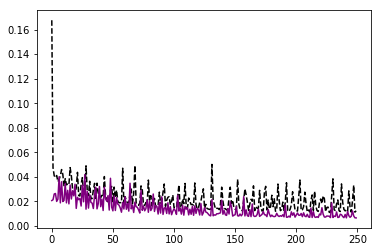

In [24]:
# training loss
plt.plot(model_output.history['loss'],c='k',linestyle='--')
plt.plot(model_output.history['val_loss'],c='purple',linestyle='-')
plt.show;

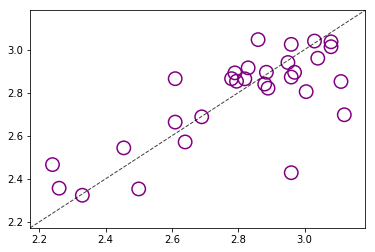

In [25]:
# spot checking prediction pattern (ideally linear)
xxx = scaler_1.inverse_transform(y_test_1.reshape(-1,1)).reshape(1,-1)[0]
# yyy = scaler_1.inverse_transform(model_all.predict([X_test_1,X_test_2,X_test_3]).reshape(1,-1)[0].reshape(1,-1))[0]
yyy = scaler_1.inverse_transform(model_all.predict([X_test_1,X_test_2,X_test_3,X_test_4,X_test_5]).reshape(1,-1)[0].reshape(1,-1))[0]

max_show = yyy.max() + yyy.max()*.10
plt.plot([0, max_show], [0, max_show], c='k', lw=1.0, linestyle='--', alpha=0.75)
plt.scatter(xxx, yyy, s=180, facecolors='none', edgecolors='purple',lw=1.5)
plt_min = min(np.min(xxx),np.min(yyy))
plt_max = max(np.max(xxx),np.max(yyy))
plt.xlim(plt_min*.97,plt_max*1.02)
plt.ylim(plt_min*.97,plt_max*1.02)
plt.show()

In [26]:
pred_vals = yyy.copy()

In [27]:
key_x = target_column
df = pd.DataFrame.from_dict(model_dict[key_x])
# set date index
df = df.set_index('date').copy()
# reorder df for conistency (numpy slicing used to reshape RNN input feeds)
col_vals = list(df.columns.values)
col_vals.remove(target_col)
col_vals = [target_col] + col_vals
df = df[col_vals].copy()

In [28]:
data = df[target_column].values
training_split_cut = int(train_test_split_pct*len(df))

green_line = data[:training_split_cut]
purple_line = []
for iter_x in np.arange(training_split_cut):
    purple_line.append(np.nan)
purple_line = purple_line + list(pred_vals)    

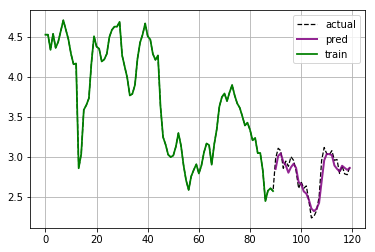

In [29]:
# plot timeseries
plt.plot(data,color='k',linestyle='--',lw=1.25)
plt.plot(purple_line, color='purple',lw=2.0,alpha=0.85)
plt.plot(green_line,color='green',lw=1.75)

plt.grid(True)
plt.legend(['actual','pred','train'], loc='best')

In [31]:
print('done')

done
